# A. Задача 1 ШАД Весна 2022 sem2



Соревнование подготовлено по аналогии с конкурсом https://yandex.ru/cup/ml/. Выражаем благодарность сотруднику Яндекса Сураджу Сингху за помощь в подготовке данных и настройке соревнования. Регистрационная форма: https://forms.yandex.ru/surveys/10037380.4d04b3ec5a8c5f0fbcf121b7d9e971aa4e91d99e/


* Механика соревнования (https://contest.yandex.ru/contest/36927/problems/): вы создаёте csv-файл с посылкой (его смысл и формат смотри в секции Формат вывода).

* Далее он разбивается на 2 части -- открытую и закрытую.

* Во время соревнования виден результат, подсчитанный по открытой части посылки, который есть 100 * MNAP@20

## Данные


In [1]:
from google.colab import drive
drive.mount('drive')

Mounted at drive


In [2]:
!cp drive/MyDrive/Colab\ Notebooks/ML-2/Lab\ 4/2021_sem3_comp_1_data.zip 2021_sem3_comp_1_data.zip

In [3]:
!unzip 2021_sem3_comp_1_data.zip

Archive:  2021_sem3_comp_1_data.zip
   creating: data/
  inflating: data/aspects.csv        
  inflating: data/features.csv       
  inflating: data/organisations.csv  
  inflating: data/reviews.csv        
  inflating: data/rubrics.csv        
  inflating: data/test_users.csv     
  inflating: data/users.csv          


In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn
from scipy.sparse import csr_matrix

import warnings
warnings.filterwarnings('ignore')

### Users/Items/Reviews

In [5]:
users = pd.read_csv('data/users.csv')
assert users['user_id'].nunique() == users.shape[0]
assert 0 == users.isna().sum().sum()
print(users.shape)
print(users['city'].value_counts())
users.head(2)

(1393008, 2)
msk    1014244
spb     378764
Name: city, dtype: int64


,user_id,city
0,12735004856856244189,msk
1,13776338520332531455,msk


In [6]:
test_users = pd.read_csv('data/test_users.csv')
test_users.head(2)

,user_id
0,11859048046981233908
1,15587804372050325574


In [7]:
items = pd.read_csv('data/organisations.csv')
assert items['org_id'].nunique() == items.shape[0]
print(items.shape)
items['average_bill'] = pd.to_numeric(items['average_bill'], errors='coerce')
items.head(2)

(68339, 6)


,org_id,city,average_bill,rating,rubrics_id,features_id
0,15903868628669802651,msk,1500.0,4.270968,30776 30774,3501685156 3501779478 20422 3502045016 3502045...
1,16076540698036998306,msk,500.0,4.375000,30771,1509 1082283206 273469383 10462 11617 35017794...


In [8]:
items.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68339 entries, 0 to 68338
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   org_id        68339 non-null  uint64 
 1   city          68339 non-null  object 
 2   average_bill  32778 non-null  float64
 3   rating        54608 non-null  float64
 4   rubrics_id    68339 non-null  object 
 5   features_id   57290 non-null  object 
dtypes: float64(2), object(3), uint64(1)
memory usage: 3.1+ MB


Max average_bill: 7502000.0


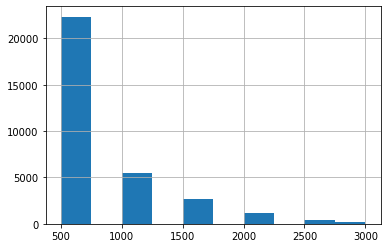

In [9]:
print('Max average_bill:', items['average_bill'].max())
items.loc[items['average_bill'] < items['average_bill'].quantile(0.99)]['average_bill'].hist()

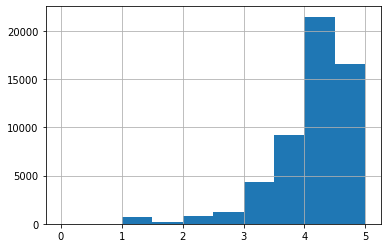

In [10]:
items['rating'].hist()

In [11]:
reviews = pd.read_csv('data/reviews.csv', low_memory=False)
print(reviews.shape)
reviews.head(2)

(4129696, 5)


,user_id,org_id,rating,ts,aspects
0,5969205021826098131,15999570556361329805,1.0,279,NaN
1,11419028914633614269,15999570556361329805,1.0,391,NaN


In [12]:
reviews.isna().sum()

user_id          0
org_id           0
rating        1362
ts               0
aspects    3407084
dtype: int64

#### Насколько активно оставляют отзывы

In [13]:
reviews_per_user = reviews.groupby('user_id')['rating'].count()
reviews_per_org = reviews.groupby('org_id')['rating'].count()

#### Aspects/Features/Rubrics

In [14]:
aspects = pd.read_csv('data/aspects.csv')
aspects.head(2)

,aspect_id,aspect_name
0,1,Бургеры
1,2,Чистота


In [15]:
assert aspects.shape[0] == aspects['aspect_id'].nunique()
print(f'Всего аспектов: {aspects.shape[0]}')

Всего аспектов: 243


In [16]:
features = pd.read_csv('data/features.csv')
features.head(2)

,feature_id,feature_name
0,1,prepress_and_post_printing_processing
1,40,products


In [17]:
assert features.shape[0] == features['feature_id'].nunique()
print(f'Всего фичей: {features.shape[0]}')

Всего фичей: 1006


In [18]:
rubrics = pd.read_csv('data/rubrics.csv')
rubrics.head(2)

,rubric_id,rubric_name
0,30519,"Булочная, пекарня"
1,30770,"Бар, паб"


In [19]:
assert rubrics.shape[0] == rubrics['rubric_id'].nunique()
print(f'Всего рубрик: {rubrics.shape[0]}')

Всего рубрик: 15


---

__Сделаем прогноз Топ популярных для тестовой выборки__

Алгоритм:
1. Возьмем отзывы только туристов (юзеров из другого города, нежели ресторан)
2. Оставим только отзывы с оценкой 5
3. Посчитаем кол-во отзывов на каждый ресторан
4. Порекомендуем Топ-20 ресторанов другого города каждому пользователю, среди тех заведений, в которых он еще не был

In [20]:
test_users_city = pd.merge(test_users, users, on='user_id', how='inner')
test_users_city_reviews = pd.merge(test_users_city, reviews, on='user_id', how='left')
test_users_df = test_users_city_reviews.groupby(['user_id', 'city'])['org_id'].apply(list).reset_index()
test_users_df = test_users_df.rename(columns={'org_id': 'visited_org_ids'})

In [21]:
reviews_user_city = pd.merge(reviews, users, on='user_id')
items_id_city = items[['org_id', 'city']].rename(columns={'city': 'org_city'})
reviews_full = pd.merge(reviews_user_city, items_id_city, on='org_id')

reviews_tourists = reviews_full.loc[(reviews_full['city'] != reviews_full['org_city']) &
                                    (reviews_full['rating'] == 5)].groupby('org_id')['rating'].count()
org_num_reviews = reviews_tourists.reset_index().rename(columns={'rating': 'num_reviews'})

items_n_reviews = pd.merge(items, org_num_reviews, on='org_id')
items_chosen = items_n_reviews.sort_values(by=['city', 'num_reviews'], ascending=[True, False])

In [22]:
def recommend_most_popular(city, visited_org_ids, items_chosen, n=20):
    available_orgs = items_chosen.loc[~items_chosen['org_id'].isin(visited_org_ids)]
    most_popular = list(available_orgs.loc[available_orgs['city'] != city]['org_id'].head(n))
    assert len(most_popular) == n
    return most_popular

In [23]:
from tqdm._tqdm_notebook import tqdm_notebook
tqdm_notebook.pandas()

test_users_df['preds_org_ids_dummy'] = test_users_df.progress_apply(lambda x: recommend_most_popular(x['city'], 
                                                                                                     x['visited_org_ids'], 
                                                                                                     items_chosen), axis=1)
test_users_df['target'] = test_users_df['preds_org_ids_dummy'].apply(lambda x: ' '.join(map(str, x)))
test_users_df[['user_id', 'target']].to_csv('submission_final.csv', sep=',', index=False)

  0%|          | 0/22485 [00:00<?, ?it/s]

In [24]:
! cp submission_final.csv drive/MyDrive/Colab\ Notebooks/ML-2/Lab\ 4/submission_final.csv

---

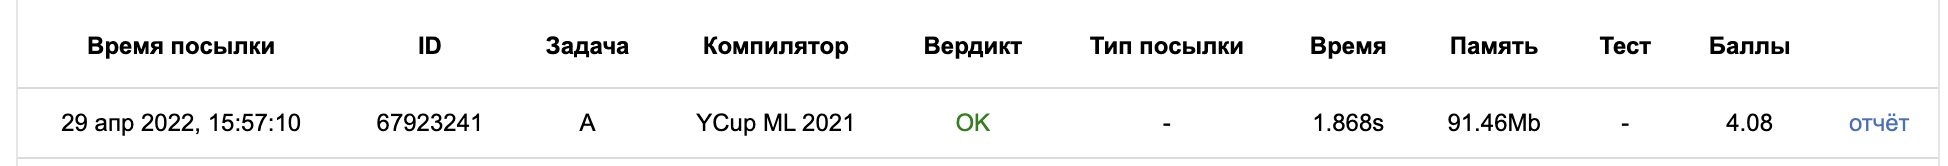